In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt


In [2]:
# Завантаження та підготовка даних
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

x_train = x_train.reshape(-1, 28 * 28).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28 * 28).astype("float32") / 255.0


In [3]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(784,)))

    for i in range(hp.Int("num_layers", 2, 4)):  # більше шарів
        units = hp.Int(f"units_{i}", min_value=128, max_value=768, step=64)
        model.add(layers.Dense(units))
        model.add(layers.BatchNormalization())  # покращує стабільність
        model.add(layers.Activation(hp.Choice(f"activation_{i}", ["relu", "tanh"])))
        model.add(layers.Dropout(hp.Float(f"dropout_{i}", 0.2, 0.4, step=0.1)))  # Dropout

    model.add(layers.Dense(10, activation="softmax"))

    # Вибір оптимізатора
    optimizer_choice = hp.Choice("optimizer", ["adam", "rmsprop"])
    if optimizer_choice == "adam":
        optimizer = keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
        )
    else:
        optimizer = keras.optimizers.RMSprop(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
        )

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [4]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    directory="keras_tuner_dir",
    project_name="fashion_mnist_dense_v2"
)

tuner.search(x_train, y_train, epochs=30, validation_split=0.1, verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

test_loss, test_acc = best_model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")


Trial 5 Complete [00h 18m 58s]
val_accuracy: 0.8934999704360962

Best val_accuracy So Far: 0.9010000228881836
Total elapsed time: 01h 23m 02s


C:\Users\User\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 768)                 │         602,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 768)                 │           3,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 384)                 │         295,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 384)                 │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 192)                 │          73,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 192)                 │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,930 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 979,402 (3.74 MB)

 Trainable params: 976,714 (3.73 MB)

 Non-trainable params: 2,688 (10.50 KB)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8934 - loss: 0.3184
Test accuracy: 0.8932


Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - accuracy: 0.9228 - loss: 0.2154 - val_accuracy: 0.8965 - val_loss: 0.3130
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.9238 - loss: 0.2152 - val_accuracy: 0.8997 - val_loss: 0.3108
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.9248 - loss: 0.2099 - val_accuracy: 0.8872 - val_loss: 0.3545
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.9251 - loss: 0.2061 - val_accuracy: 0.8988 - val_loss: 0.3080
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.9260 - loss: 0.2062 - val_accuracy: 0.8992 - val_loss: 0.3038
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.9258 - loss: 0.2046 - val_accuracy: 0.8983 - val_loss: 0.3069
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.9300 - loss: 0.1963 - val_accuracy: 0.8968 - val_loss: 0.3143
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.9285 -

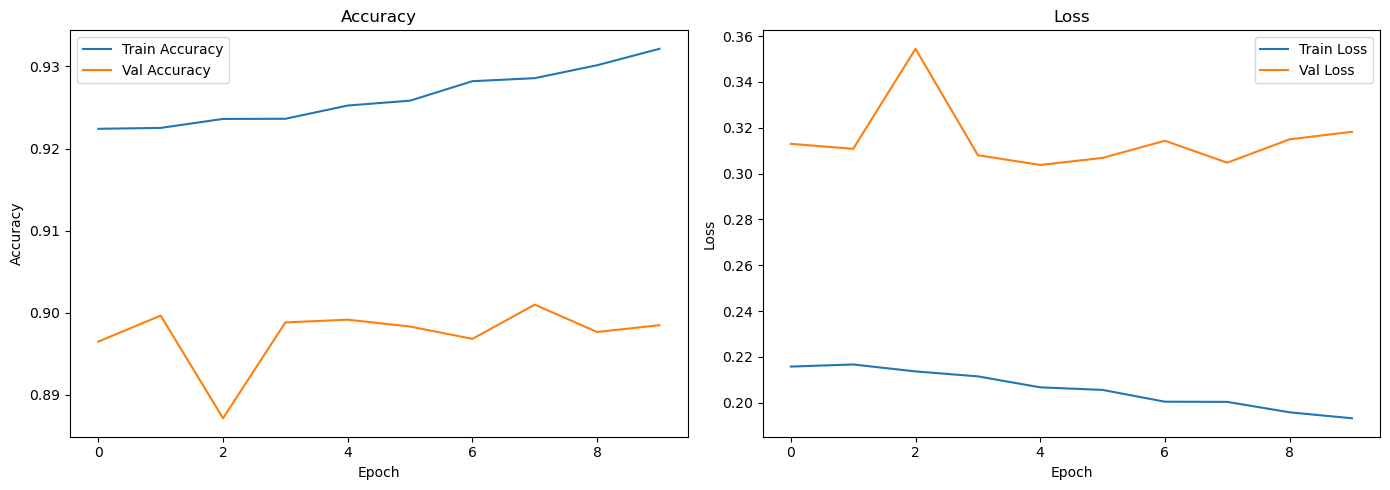

In [5]:
history = best_model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


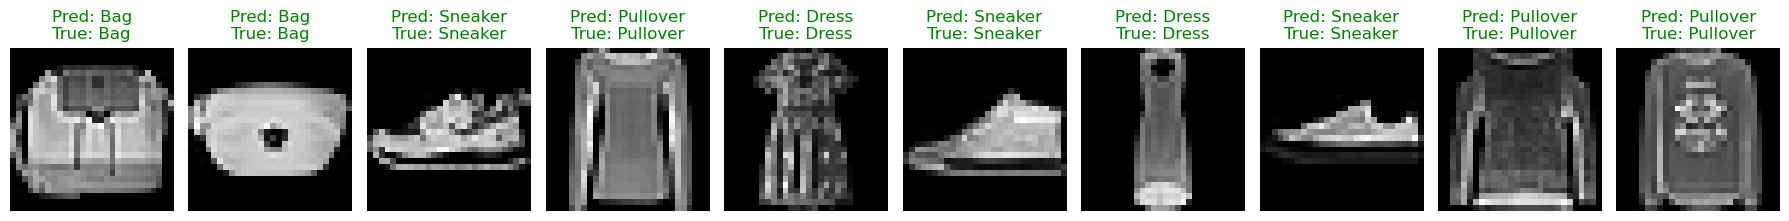

In [8]:
pred_probs = best_model.predict(x_test)
pred_labels = np.argmax(pred_probs, axis=1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

num_images = 10
random_indices = np.random.choice(len(x_test), num_images, replace=False)

plt.figure(figsize=(18, 4))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    true_label = class_names[y_test[idx]]
    pred_label = class_names[pred_labels[idx]]
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()